# IMPORTED LIBRARIES

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

#%matplotlib inline
plt.style.use('seaborn-whitegrid')

# READING THE DATA

In [2]:
training_data = pd.read_csv("data/income-train.csv")
test_data = pd.read_csv("data/income-test.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
training_data.dtypes

Instance                                                      int64
Year of Record                                              float64
Housing Situation                                            object
Crime Level in the City of Employement                        int64
Work Experience in Current Job [years]                       object
Satisfation with employer                                    object
Gender                                                       object
Age                                                           int64
Country                                                      object
Size of City                                                  int64
Profession                                                   object
University Degree                                            object
Wears Glasses                                                 int64
Hair Color                                                   object
Body Height [cm]                                

In [5]:
training_data.drop_duplicates(inplace=True)

In [7]:
training_data.dropna(subset=['Year of Record'], inplace=True)

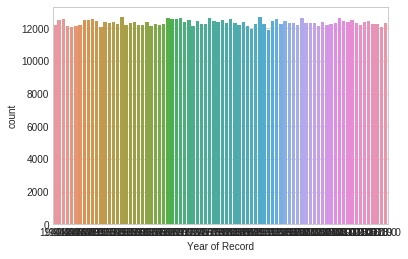

In [8]:
sns.countplot(training_data['Year of Record'])

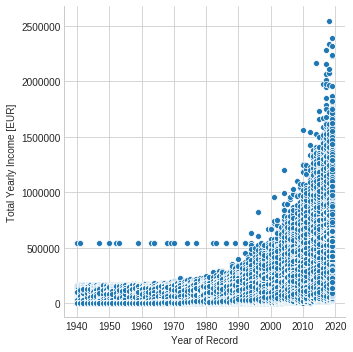

In [9]:
sns.relplot(x="Year of Record", y="Total Yearly Income [EUR]", data=training_data[["Year of Record", "Total Yearly Income [EUR]"]]);

In [10]:
training_data['Housing Situation'].value_counts(dropna=False)

Castle              124093
Large Apartment     123777
nA                  123560
Medium House        123549
Large House         123399
Small House         123207
Medium Apartment     97132
0                    75944
0                    65536
Small Apartment       7502
Name: Housing Situation, dtype: int64

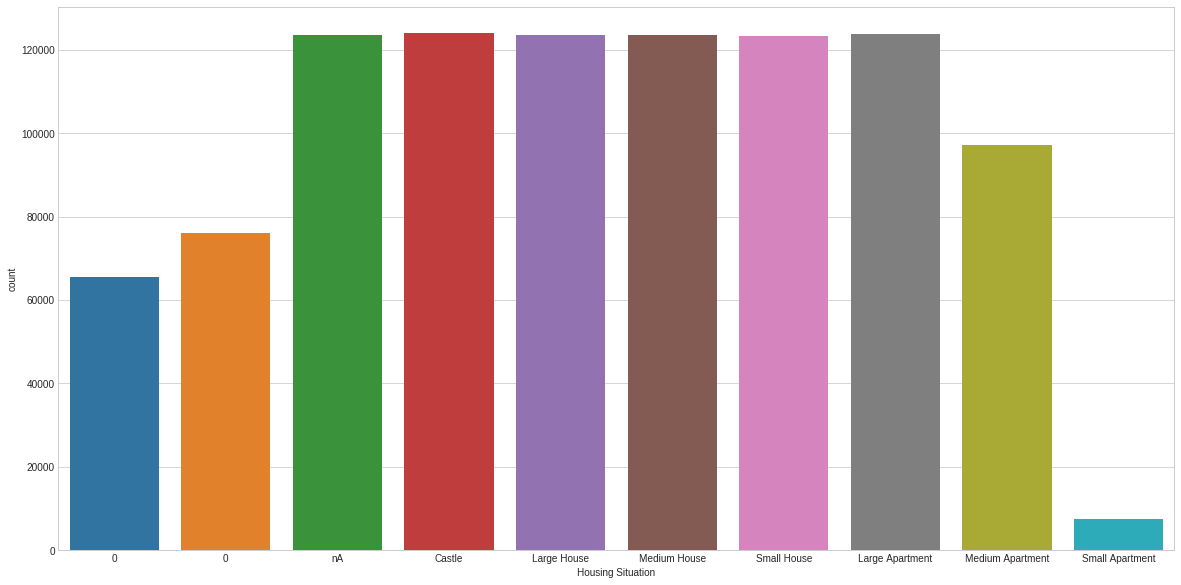

In [21]:
sns.countplot(training_data['Housing Situation'])

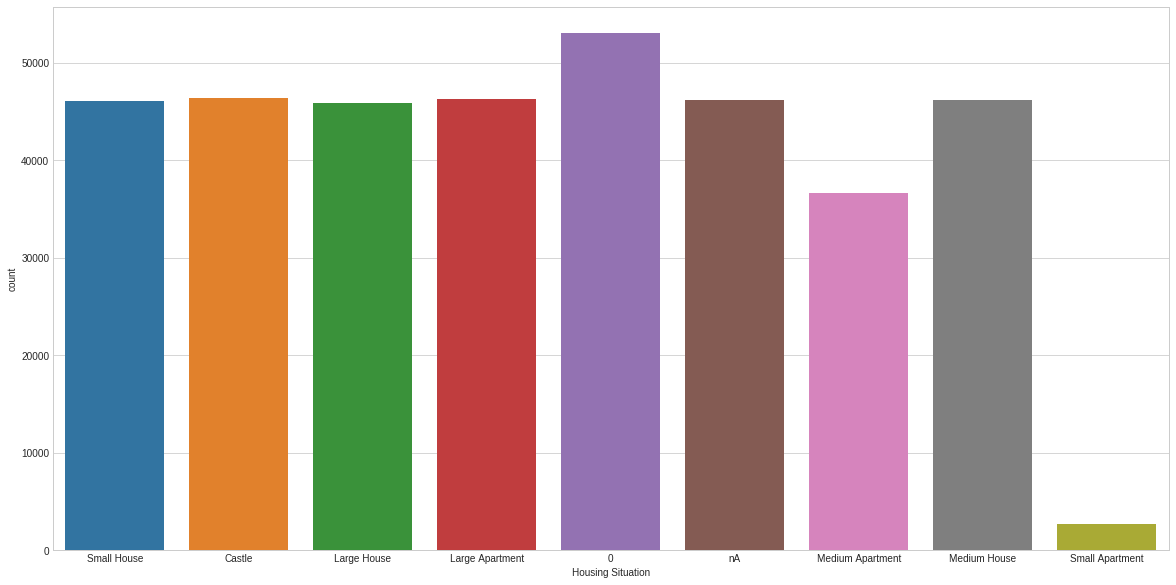

In [22]:
sns.countplot(test_data['Housing Situation'])

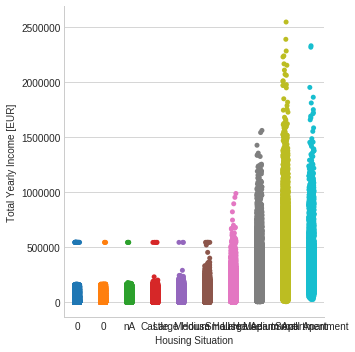

In [18]:
sns.catplot(x="Housing Situation", y="Total Yearly Income [EUR]", data=training_data[["Housing Situation", "Total Yearly Income [EUR]"]])